## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [37]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [38]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [39]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [40]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

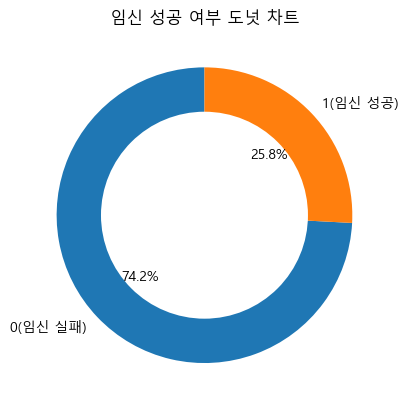

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [42]:
# '시술_시기_코드' 변수의 값이 'TRDQAZ'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRDQAZ'] 
IVF_test = test[test['시술_시기_코드'] == 'TRDQAZ']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [43]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRDQAZ    0.754574  0.245426  29405  9564  38969


In [44]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [45]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
만18-34세   0.692198  0.307802  10167.0  4521.0  14688
만35-37세   0.733174  0.266826   6449.0  2347.0   8796
만38-39세   0.785125  0.214875   4571.0  1251.0   5822
만40-42세   0.842637  0.157363   5087.0   950.0   6037
만43-44세   0.878543  0.121457   1953.0   270.0   2223
만45-50세   0.830445  0.169555   1102.0   225.0   1327
알 수 없음    1.000000  0.000000     76.0     0.0     76


In [46]:
test['시술_당시_나이'].value_counts()

만18-34세    5189
만35-37세    3082
만40-42세    2063
만38-39세    2009
만43-44세     781
만45-50세     461
알 수 없음       25
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [47]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
3.0       1.000000  0.000000   3.0  0.0      3
6.0       0.000000  1.000000   0.0  2.0      2
7.0       1.000000  0.000000   1.0  0.0      1
8.0       1.000000  0.000000   2.0  0.0      2
9.0       1.000000  0.000000   8.0  0.0      8
10.0      0.800000  0.200000   8.0  2.0     10
11.0      0.833333  0.166667  20.0  4.0     24
12.0      0.850000  0.150000  17.0  3.0     20
13.0      0.958333  0.041667  23.0  1.0     24
14.0      0.900000  0.100000  27.0  3.0     30
15.0      0.705882  0.294118  12.0  5.0     17
16.0      0.789474  0.210526  15.0  4.0     19
17.0      0.750000  0.250000   6.0  2.0      8
18.0      0.750000  0.250000   6.0  2.0      8
19.0      1.000000  0.000000   4.0  0.0      4
20.0      0.714286  0.285714   5.0  2.0      7


In [48]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [49]:
train['임신_시도_또는_마지막_임신_경과_연수'].value_counts()

unknown    38782
12-14년        74
15-17년        44
9-11년         42
18-20년        19
6-8년           5
3-5년           3
0-2년           0
Name: 임신_시도_또는_마지막_임신_경과_연수, dtype: int64

### 4. 시술_유형

IVF 또는 DI 시술 여부

In [50]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.887967  0.112033    856   108    964
IVF       0.751191  0.248809  28549  9456  38005


In [51]:
test['시술_유형'].value_counts()

IVF    13327
DI       283
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [52]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                 group  '임신_성공_여부' count     ratio  Total
0                  FER                 1  0.333333      3
1           Generic DI                 1  0.050000     20
2                  ICI                 0  0.000000      4
3                 ICSI              4713  0.257893  18275
4            ICSI / AH                 0  0.000000      2
5   ICSI / BLASTOCYST                  2  0.400000      5
6            ICSI:ICSI                 6  0.008054    745
7             ICSI:IVF                17  0.128788    132
8         ICSI:Unknown                 2  0.038462     52
9                  IUI               107  0.114807    932
10                 IVF              3341  0.244798  13648
11            IVF / AH                 0  0.000000      1
12    IVF / BLASTOCYST                 1  0.125000      8
13            IVF:ICSI                 9  0.150000     60
14             IVF:IVF                 0  0.000000    308
15         IVF:Unknown                 2  0.071429

In [53]:
test['특정_시술_유형'].value_counts()

ICSI                           6349
IVF                            4885
Unknown                        1604
IUI                             266
ICSI:ICSI                       258
IVF:IVF                         125
ICSI:IVF                         46
IVF:ICSI                         20
ICSI:Unknown                     18
IVF:Unknown                      16
Generic DI                       10
IVI                               5
IVF / BLASTOCYST                  3
ICI                               2
IVF:Unknown:Unknown:Unknown       1
ICSI / AH                         1
ICSI / BLASTOCYST                 1
Name: 특정_시술_유형, dtype: int64

In [54]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [55]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [56]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.950000  0.050000     19.0     1.0     20
ICI                1.000000  0.000000      4.0     0.0      4
ICSI               0.753281  0.246719  14466.0  4738.0  19204
ICSI / AH          1.000000  0.000000      2.0     0.0      2
ICSI / BLASTOCYST  0.600000  0.400000      3.0     2.0      5
IUI                0.885193  0.114807    825.0   107.0    932
IVF                0.761322  0.238678  10692.0  3352.0  14044
IVF / AH           1.000000  0.000000      1.0     0.0      1
IVF / BLASTOCYST   0.875000  0.125000      7.0     1.0      8
IVI                1.000000  0.000000      8.0     0.0      8
Unknown            0.712537  0.287463   3376.0  1362.0   4738


In [57]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 6671
IVF                  5047
Unknown              1604
IUI                   266
Generic DI             10
IVI                     5
IVF / BLASTOCYST        3
ICI                     2
ICSI / AH               1
ICSI / BLASTOCYST       1
Name: 변환된_특정_시술_유형, dtype: int64

In [58]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [59]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                               group  '임신_성공_여부' count     ratio  Total
0           (Generic DI, 0, 0, 0, 0)                 1  0.050000     20
1                  (ICI, 0, 0, 0, 0)                 0  0.000000      4
2                 (ICSI, 1, 0, 0, 0)              4713  0.257893  18275
3            (ICSI / AH, 1, 0, 1, 0)                 0  0.000000      2
4   (ICSI / BLASTOCYST , 1, 0, 0, 1)                 2  0.400000      5
5            (ICSI:ICSI, 1, 0, 0, 0)                 6  0.008054    745
6             (ICSI:IVF, 1, 0, 0, 0)                17  0.128788    132
7         (ICSI:Unknown, 1, 0, 0, 0)                 2  0.038462     52
8                  (IUI, 0, 0, 0, 0)               107  0.114807    932
9                  (IVF, 0, 1, 0, 0)              3341  0.244798  13648
10            (IVF / AH, 0, 1, 1, 0)                 0  0.000000      1
11    (IVF / BLASTOCYST, 0, 1, 0, 1)   

In [60]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [61]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.747406  0.252594   7418  2507   9925
1         0.757033  0.242967  21985  7056  29041


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [62]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                     0         1        0       1  Total
variable                                                
기록되지 않은 시행    0.755041  0.244959  21567.0  6997.0  28564
세트로타이드 (억제제)  1.000000  0.000000      1.0     0.0      1
알 수 없음        0.753293  0.246707   7835.0  2566.0  10401


In [63]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    10094
알 수 없음         3516
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [64]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.804539  0.195461  21375  5193  26568
1.0       0.627252  0.372748   7172  4262  11434


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [65]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.867503  0.132497  622  95    717


In [66]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 38249
결측값 개수: 0


In [67]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.752464  0.247536  28781  9468  38249
1.0       0.867503  0.132497    622    95    717


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [68]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.748996  0.251004  27975  9375  37350
1.0       0.877301  0.122699    572    80    652


In [69]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9281  0.253247  36648
1  (0.0, 1.0)                94  0.133903    702
2  (1.0, 0.0)                79  0.124019    637
3  (1.0, 1.0)                 1  0.066667     15


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [70]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754181  0.245819  29269  9540  38809
1         0.853503  0.146497    134    23    157


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [71]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754397  0.245603  29340  9552  38892
1         0.851351  0.148649     63    11     74


In [72]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9529  0.246005  38735
1  (0, 1)                11  0.148649     74
2  (1, 0)                23  0.146497    157


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [73]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754034  0.245966  29252  9542  38794
1         0.877907  0.122093    151    21    172


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [74]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754564  0.245436  29348  9546  38894
1         0.763889  0.236111     55    17     72


In [75]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9525  0.245984  38722
1  (0, 1)                17  0.236111     72
2  (1, 0)                21  0.122093    172


In [76]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)              9525  0.245991  38721
1  (0, 0, 0, 1)                 2  1.000000      2
2  (0, 0, 1, 0)                 2  0.166667     12
3  (0, 1, 0, 1)                 9  0.183673     49
4  (0, 1, 1, 0)                 2  0.080000     25
5  (1, 0, 0, 0)                 0  0.000000      1
6  (1, 0, 0, 1)                 6  0.285714     21
7  (1, 0, 1, 0)                17  0.125926    135


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [77]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754042  0.245958  29244  9539  38783
1         0.868852  0.131148    159    24    183


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [78]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754523  0.245477  29363  9553  38916
1         0.800000  0.200000     40    10     50


In [79]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9529  0.246018  38733
1  (0, 1)                10  0.200000     50
2  (1, 0)                24  0.131148    183


In [80]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              9525  0.245997  38720
1   (0, 0, 0, 0, 1, 0)                 0  0.000000      1
2   (0, 0, 0, 1, 0, 0)                 2  1.000000      2
3   (0, 0, 1, 0, 0, 0)                 2  0.222222      9
4   (0, 0, 1, 0, 1, 0)                 0  0.000000      3
5   (0, 1, 0, 1, 0, 1)                 9  0.191489     47
6   (0, 1, 0, 1, 1, 0)                 0  0.000000      2
7   (0, 1, 1, 0, 0, 1)                 1  0.333333      3
8   (0, 1, 1, 0, 1, 0)                 1  0.045455     22
9   (1, 0, 0, 0, 1, 0)                 0  0.000000      1
10  (1, 0, 0, 1, 1, 0)                 6  0.285714     21
11  (1, 0, 1, 0, 0, 0)                 0  0.000000      2
12  (1, 0, 1, 0, 1, 0)                17  0.127820    133


### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [81]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.756735  0.243265  21853  7025  28878
1         0.748414  0.251586   7550  2538  10088


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [82]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.756555  0.243445  26083  8393  34476
1         0.739421  0.260579   3320  1170   4490


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [83]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.766675  0.233325  19541  5947  25488
1         0.731711  0.268289   9862  3616  13478


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [84]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.759138  0.240862  25753  8171  33924
1         0.723919  0.276081   3650  1392   5042


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [85]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754581  0.245419  29403  9563  38966


In [86]:
test['불임_원인_-_여성_요인'].value_counts()

0    13610
Name: 불임_원인_-_여성_요인, dtype: int64

In [87]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [88]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.754568  0.245432  29401.0  9563.0  38964
1         1.000000  0.000000      2.0     0.0      2


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [89]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.756462  0.243538  27508  8856  36364
1         0.728286  0.271714   1895   707   2602


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [90]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.754524  0.245476  29394.0  9563.0  38957
1         1.000000  0.000000      9.0     0.0      9


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [91]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754581  0.245419  29403  9563  38966


In [92]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    13610
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [93]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [94]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

               0       1        0       1  Total
variable                                        
0         0.7546  0.2454  29403.0  9562.0  38965
1         0.0000  1.0000      0.0     1.0      1


In [95]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [96]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.754562  0.245438  29400.0  9563.0  38963
1         1.000000  0.000000      3.0     0.0      3


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [97]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    191.0     0.0    191
기증용, 난자 저장용          1.000000  0.000000      7.0     0.0      7
기증용, 배아 저장용          1.000000  0.000000     28.0     0.0     28
기증용, 배아 저장용, 현재 시술용  0.500000  0.500000      1.0     1.0      2
기증용, 현재 시술용          0.657568  0.342432    265.0   138.0    403
난자 저장용               1.000000  0.000000    476.0     0.0    476
난자 저장용, 배아 저장용       1.000000  0.000000      1.0     0.0      1
배아 저장용               0.998899  0.001101   3630.0     4.0   3634
배아 저장용, 현재 시술용       0.840000  0.160000     42.0     8.0     50
연구용, 현재 시술용          1.000000  0.000000      1.0     0.0      1
현재 시술용               0.719835  0.280165  23905.0  9304.0  33209


In [98]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [99]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    191.0     0.0    191
기증용, 난자 저장용          1.000000  0.000000      7.0     0.0      7
기증용, 배아 저장용          1.000000  0.000000     28.0     0.0     28
기증용, 배아 저장용, 현재 시술용  0.500000  0.500000      1.0     1.0      2
기증용, 현재 시술용          0.657568  0.342432    265.0   138.0    403
난자 저장용               1.000000  0.000000    476.0     0.0    476
난자 저장용, 배아 저장용       1.000000  0.000000      1.0     0.0      1
배아 저장용               0.998899  0.001101   3630.0     4.0   3634
배아 저장용, 현재 시술용       0.840000  0.160000     42.0     8.0     50
현재 시술용               0.719835  0.280165  23905.0  9304.0  33209


In [100]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용            11619
배아 저장용             1251
기증용, 현재 시술용         172
난자 저장용              171
기증용                  68
배아 저장용, 현재 시술용       27
기증용, 배아 저장용          15
기증용, 난자 저장용           4
Name: 배아_생성_주요_이유, dtype: int64

In [101]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 964
결측값 개수: 0


In [102]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [103]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [104]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [105]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [106]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

           group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0)               108  0.112033    964
1   (0, 0, 0, 1)                 4  0.001101   3634
2   (0, 0, 1, 0)                 0  0.000000    476
3   (0, 0, 1, 1)                 0  0.000000      1
4   (0, 1, 0, 0)                 0  0.000000    191
5   (0, 1, 0, 1)                 0  0.000000     28
6   (0, 1, 1, 0)                 0  0.000000      7
7   (1, 0, 0, 0)              9304  0.280165  33209
8   (1, 0, 0, 1)                 8  0.160000     50
9   (1, 1, 0, 0)               138  0.342432    403
10  (1, 1, 0, 1)                 1  0.500000      2


In [107]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.978872  0.021128   5189   112   5301
1         0.719255  0.280745  24213  9451  33664


In [108]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [109]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.734422  0.265578  11374  4113  15487
1회        0.757139  0.242861   6045  1939   7984
2회        0.763317  0.236683   4299  1333   5632
3회        0.769104  0.230896   2798   840   3638
4회        0.777247  0.222753   1790   513   2303
5회        0.789508  0.210492   1219   325   1544
6회 이상     0.789651  0.210349   1877   500   2377


In [110]:
test['총_시술_횟수'].value_counts()

0회       5463
1회       2773
2회       1928
3회       1276
4회        840
6회 이상     806
5회        524
Name: 총_시술_횟수, dtype: int64

In [111]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.734422  0.265578  11374  4113  15487
1         0.757139  0.242861   6045  1939   7984
2         0.763317  0.236683   4299  1333   5632
3         0.769104  0.230896   2798   840   3638
4         0.777247  0.222753   1790   513   2303
5         0.789508  0.210492   1219   325   1544
6         0.789651  0.210349   1877   500   2377


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [112]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.743328  0.256672  13704  4732  18436
1회        0.759326  0.240674   6534  2071   8605
2회        0.761096  0.238904   3944  1238   5182
3회        0.759516  0.240484   2195   695   2890
4회        0.777190  0.222810   1322   379   1701
5회        0.805416  0.194584    803   194    997
6회 이상     0.779896  0.220104    900   254   1154


In [113]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743328  0.256672  13704  4732  18436
1         0.759326  0.240674   6534  2071   8605
2         0.761096  0.238904   3944  1238   5182
3         0.759516  0.240484   2195   695   2890
4         0.777190  0.222810   1322   379   1701
5         0.805416  0.194584    803   194    997
6         0.779896  0.220104    900   254   1154


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [114]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.738277  0.261723  12155  4309  16464
1회        0.756964  0.243036   6223  1998   8221
2회        0.760107  0.239893   4268  1347   5615
3회        0.768191  0.231809   2671   806   3477
4회        0.778860  0.221140   1599   454   2053
5회        0.793182  0.206818   1047   273   1320
6회 이상     0.792837  0.207163   1439   376   1815


In [115]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738277  0.261723  12155  4309  16464
1         0.756964  0.243036   6223  1998   8221
2         0.760107  0.239893   4268  1347   5615
3         0.768191  0.231809   2671   806   3477
4         0.778860  0.221140   1599   454   2053
5         0.793182  0.206818   1047   273   1320
6         0.792837  0.207163   1439   376   1815


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [116]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.752712  0.247288  27681  9094  36775
1회        0.812636  0.187364    373    86    459
2회        0.786749  0.213251    380   103    483
3회        0.753176  0.246824    415   136    551
4회        0.789062  0.210938    202    54    256
5회        0.840659  0.159341    153    29    182
6회 이상     0.764479  0.235521    198    61    259


In [117]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.752712  0.247288  27681  9094  36775
1         0.812636  0.187364    373    86    459
2         0.786749  0.213251    380   103    483
3         0.753176  0.246824    415   136    551
4         0.789062  0.210938    202    54    256
5         0.840659  0.159341    153    29    182
6         0.764479  0.235521    198    61    259


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [118]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.757617  0.242383  23746.0  7597.0  31343
1회        0.743710  0.256290   4759.0  1640.0   6399
2회        0.731286  0.268714    762.0   280.0   1042
3회        0.743421  0.256579    113.0    39.0    152
4회        0.750000  0.250000     18.0     6.0     24
5회        1.000000  0.000000      4.0     0.0      4
6회 이상     0.000000  1.000000      0.0     1.0      1


In [119]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.757617  0.242383  23746.0  7597.0  31343
1         0.743710  0.256290   4759.0  1640.0   6399
2         0.731286  0.268714    762.0   280.0   1042
3         0.743421  0.256579    113.0    39.0    152
4         0.750000  0.250000     18.0     6.0     24
5         1.000000  0.000000      4.0     0.0      4
6         0.000000  1.000000      0.0     1.0      1


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [120]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.758084  0.241916  24076.0  7683.0  31759
1회        0.740857  0.259143   4497.0  1573.0   6070
2회        0.729618  0.270382    707.0   262.0    969
3회        0.724638  0.275362    100.0    38.0    138
4회        0.750000  0.250000     18.0     6.0     24
5회        1.000000  0.000000      4.0     0.0      4
6회 이상     0.000000  1.000000      0.0     1.0      1


In [121]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.758084  0.241916  24076.0  7683.0  31759
1         0.740857  0.259143   4497.0  1573.0   6070
2         0.729618  0.270382    707.0   262.0    969
3         0.724638  0.275362    100.0    38.0    138
4         0.750000  0.250000     18.0     6.0     24
5         1.000000  0.000000      4.0     0.0      4
6         0.000000  1.000000      0.0     1.0      1


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [122]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.754109  0.245891  29040.0  9469.0  38509
1회        0.796020  0.203980    320.0    82.0    402
2회        0.744681  0.255319     35.0    12.0     47
3회        1.000000  0.000000      7.0     0.0      7


In [123]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.754109  0.245891  29040.0  9469.0  38509
1         0.796020  0.203980    320.0    82.0    402
2         0.744681  0.255319     35.0    12.0     47
3         1.000000  0.000000      7.0     0.0      7


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [124]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.757663  0.242337  25237.0  8072.0  33309
1회        0.736591  0.263409   3859.0  1380.0   5239
2회        0.741333  0.258667    278.0    97.0    375
3회        0.657895  0.342105     25.0    13.0     38
4회        0.666667  0.333333      2.0     1.0      3
5회        1.000000  0.000000      1.0     0.0      1


In [125]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.757663  0.242337  25237.0  8072.0  33309
1         0.736591  0.263409   3859.0  1380.0   5239
2         0.741333  0.258667    278.0    97.0    375
3         0.657895  0.342105     25.0    13.0     38
4         0.666667  0.333333      2.0     1.0      3
5         1.000000  0.000000      1.0     0.0      1


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [126]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.757816  0.242184  25499.0  8149.0  33648
1회        0.734901  0.265099   3626.0  1308.0   4934
2회        0.730994  0.269006    250.0    92.0    342
3회        0.648649  0.351351     24.0    13.0     37
4회        0.666667  0.333333      2.0     1.0      3
5회        1.000000  0.000000      1.0     0.0      1


In [127]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.757816  0.242184  25499.0  8149.0  33648
1         0.734901  0.265099   3626.0  1308.0   4934
2         0.730994  0.269006    250.0    92.0    342
3         0.648649  0.351351     24.0    13.0     37
4         0.666667  0.333333      2.0     1.0      3
5         1.000000  0.000000      1.0     0.0      1


In [128]:
test['IVF_출산_횟수'].value_counts()

0    11764
1     1714
2      118
3       14
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [129]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.754409  0.245591  29133.0  9484.0  38617
1회        0.764706  0.235294    247.0    76.0    323
2회        0.875000  0.125000     21.0     3.0     24
3회        1.000000  0.000000      1.0     0.0      1


In [130]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.754409  0.245591  29133.0  9484.0  38617
1         0.764706  0.235294    247.0    76.0    323
2         0.875000  0.125000     21.0     3.0     24
3         1.000000  0.000000      1.0     0.0      1


In [131]:
test['DI_출산_횟수'].value_counts()

0    13506
1       99
2        5
Name: DI_출산_횟수, dtype: int64

In [132]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [133]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [134]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [135]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.795717  0.204283  6949.0  1784.0   8733
1.0       0.908313  0.091687  2229.0   225.0   2454
2.0       0.838753  0.161247  2502.0   481.0   2983
3.0       0.781759  0.218241  2400.0   670.0   3070
4.0       0.743764  0.256236  2296.0   791.0   3087
5.0       0.702264  0.297736  2078.0   881.0   2959
6.0       0.701279  0.298721  1864.0   794.0   2658
7.0       0.674915  0.325085  1582.0   762.0   2344
8.0       0.665133  0.334867  1301.0   655.0   1956
9.0       0.670538  0.329462  1097.0   539.0   1636
10.0      0.675220  0.324780   921.0   443.0   1364
11.0      0.652695  0.347305   654.0   348.0   1002
12.0      0.684332  0.315668   594.0   274.0    868
13.0      0.660911  0.339089   421.0   216.0    637
14.0      0.667283  0.332717   361.0   180.0    541
15.0      0.711392  0.288608   281.0   114.0    395
16.0      0.739583  0.260417   213

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [136]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.750786  0.249214  14798.0  4912.0  19710
1.0       0.950920  0.049080    775.0    40.0    815
2.0       0.892857  0.107143    950.0   114.0   1064
3.0       0.841346  0.158654   1050.0   198.0   1248
4.0       0.802736  0.197264   1115.0   274.0   1389
5.0       0.761509  0.238491   1191.0   373.0   1564
6.0       0.739759  0.260241   1228.0   432.0   1660
7.0       0.716273  0.283727   1030.0   408.0   1438
8.0       0.699571  0.300429    978.0   420.0   1398
9.0       0.707803  0.292197    889.0   367.0   1256
10.0      0.682268  0.317732    758.0   353.0   1111
11.0      0.694725  0.305275    619.0   272.0    891
12.0      0.668241  0.331759    566.0   281.0    847
13.0      0.676923  0.323077    440.0   210.0    650
14.0      0.707904  0.292096    412.0   170.0    582
15.0      0.674672  0.325328    309.0   149.0    458
16.0      0.660

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [137]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.758484  0.241516  15445.0  4918.0  20363
1.0       0.914498  0.085502   1476.0   138.0   1614
2.0       0.833081  0.166919   1652.0   331.0   1983
3.0       0.784381  0.215619   1597.0   439.0   2036
4.0       0.731533  0.268467   1436.0   527.0   1963
5.0       0.704803  0.295197   1306.0   547.0   1853
6.0       0.696602  0.303398   1148.0   500.0   1648
7.0       0.678676  0.321324    923.0   437.0   1360
8.0       0.661172  0.338828    722.0   370.0   1092
9.0       0.660297  0.339703    622.0   320.0    942
10.0      0.675939  0.324061    486.0   233.0    719
11.0      0.664193  0.335807    358.0   181.0    539
12.0      0.702461  0.297539    314.0   133.0    447
13.0      0.680000  0.320000    221.0   104.0    325
14.0      0.697183  0.302817    198.0    86.0    284
15.0      0.737864  0.262136    152.0    54.0    206
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [138]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.999033  0.000967   8261     8   8269
1.0       0.662287  0.337713  10988  5603  16591
2.0       0.696668  0.303332   8468  3687  12155
3.0       0.840771  0.159229    829   157    986


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [139]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.794296  0.205704  18299  4739  23038
1.0       0.657244  0.342756   5208  2716   7924
2.0       0.705392  0.294608   4566  1907   6473
3.0       0.835689  0.164311    473    93    566


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [140]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.783606  0.216394  17762.0  4905.0  22667
1.0       0.699115  0.300885   2686.0  1156.0   3842
2.0       0.685631  0.314369   2362.0  1083.0   3445
3.0       0.677108  0.322892   1686.0   804.0   2490
4.0       0.676950  0.323050   1163.0   555.0   1718
5.0       0.697264  0.302736    790.0   343.0   1133
6.0       0.715686  0.284314    584.0   232.0    816
7.0       0.731978  0.268022    396.0   145.0    541
8.0       0.787342  0.212658    311.0    84.0    395
9.0       0.785714  0.214286    198.0    54.0    252
10.0      0.804020  0.195980    160.0    39.0    199
11.0      0.813008  0.186992    100.0    23.0    123
12.0      0.868132  0.131868     79.0    12.0     91
13.0      0.906250  0.093750     58.0     6.0     64
14.0      0.918033  0.081967     56.0     5.0     61
15.0      0.880000  0.120000     22.0     3.0     25
16.0      0.96296

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [141]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.763430  0.236570  22425.0  6949.0  29374
1.0       0.703020  0.296980   1676.0   708.0   2384
2.0       0.688036  0.311964   1363.0   618.0   1981
3.0       0.676366  0.323634    953.0   456.0   1409
4.0       0.698616  0.301384    656.0   283.0    939
5.0       0.716007  0.283993    416.0   165.0    581
6.0       0.724566  0.275434    292.0   111.0    403
7.0       0.768953  0.231047    213.0    64.0    277
8.0       0.804469  0.195531    144.0    35.0    179
9.0       0.826446  0.173554    100.0    21.0    121
10.0      0.791667  0.208333     76.0    20.0     96
11.0      0.854839  0.145161     53.0     9.0     62
12.0      0.853659  0.146341     35.0     6.0     41
13.0      0.891892  0.108108     33.0     4.0     37
14.0      0.942857  0.057143     33.0     2.0     35
15.0      0.846154  0.153846     11.0     2.0     13
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [142]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.755798  0.244202  23723.0  7665.0  31388
1.0       0.743013  0.256987   2313.0   800.0   3113
2.0       0.714900  0.285100   1329.0   530.0   1859
3.0       0.758900  0.241100    469.0   149.0    618
4.0       0.733333  0.266667    231.0    84.0    315
5.0       0.698492  0.301508    139.0    60.0    199
6.0       0.701863  0.298137    113.0    48.0    161
7.0       0.741935  0.258065     69.0    24.0     93
8.0       0.637681  0.362319     44.0    25.0     69
9.0       0.604167  0.395833     29.0    19.0     48
10.0      0.720930  0.279070     31.0    12.0     43
11.0      0.708333  0.291667     17.0     7.0     24
12.0      0.541667  0.458333     13.0    11.0     24
13.0      0.333333  0.666667      3.0     6.0      9
14.0      0.666667  0.333333      8.0     4.0     12
15.0      0.500000  0.500000      3.0     3.0      6
16.0      0.71428

### 47. 해동_난자_수

동결 해동된 난자의 수

In [143]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.751319  0.248681  28191.0  9331.0  37522
1.0       1.000000  0.000000      8.0     0.0      8
2.0       1.000000  0.000000      9.0     0.0      9
3.0       0.952381  0.047619     20.0     1.0     21
4.0       0.936170  0.063830     44.0     3.0     47
5.0       0.864865  0.135135     32.0     5.0     37
6.0       0.771429  0.228571     27.0     8.0     35
7.0       0.761905  0.238095     32.0    10.0     42
8.0       0.600000  0.400000     54.0    36.0     90
9.0       0.727273  0.272727     32.0    12.0     44
10.0      0.720000  0.280000     18.0     7.0     25
11.0      0.640000  0.360000     16.0     9.0     25
12.0      0.640000  0.360000     16.0     9.0     25
13.0      0.750000  0.250000      9.0     3.0     12
14.0      0.666667  0.333333     14.0     7.0     21
15.0      0.428571  0.571429      6.0     8.0     14
16.0      0.500000

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [144]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.726002  0.273998  6391.0  2412.0   8803
1.0       0.958980  0.041020   865.0    37.0    902
2.0       0.914742  0.085258  1030.0    96.0   1126
3.0       0.873999  0.126001  1200.0   173.0   1373
4.0       0.829857  0.170143  1273.0   261.0   1534
5.0       0.808333  0.191667  1455.0   345.0   1800
6.0       0.787177  0.212823  1461.0   395.0   1856
7.0       0.760870  0.239130  1470.0   462.0   1932
8.0       0.729474  0.270526  1386.0   514.0   1900
9.0       0.731177  0.268823  1379.0   507.0   1886
10.0      0.724484  0.275516  1299.0   494.0   1793
11.0      0.714539  0.285461  1209.0   483.0   1692
12.0      0.689295  0.310705  1056.0   476.0   1532
13.0      0.673714  0.326286   956.0   463.0   1419
14.0      0.681564  0.318436   854.0   399.0   1253
15.0      0.684594  0.315406   751.0   346.0   1097
16.0      0.681771  0.318229   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [145]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.747198  0.252802  27937.0  9452.0  37389
1.0       1.000000  0.000000     48.0     0.0     48
2.0       1.000000  0.000000     45.0     0.0     45
3.0       1.000000  0.000000     49.0     0.0     49
4.0       0.978261  0.021739     45.0     1.0     46
5.0       0.980769  0.019231     51.0     1.0     52
6.0       1.000000  0.000000     45.0     0.0     45
7.0       1.000000  0.000000     38.0     0.0     38
8.0       1.000000  0.000000     47.0     0.0     47
9.0       0.967742  0.032258     30.0     1.0     31
10.0      1.000000  0.000000     28.0     0.0     28
11.0      1.000000  0.000000     22.0     0.0     22
12.0      1.000000  0.000000     23.0     0.0     23
13.0      1.000000  0.000000     17.0     0.0     17
14.0      1.000000  0.000000     22.0     0.0     22
15.0      1.000000  0.000000     20.0     0.0     20
16.0      1.00

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [146]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.770115  0.229885  5963.0  1780.0   7743
1.0       0.949486  0.050514  1109.0    59.0   1168
2.0       0.896831  0.103169  1330.0   153.0   1483
3.0       0.846022  0.153978  1478.0   269.0   1747
4.0       0.804963  0.195037  1622.0   393.0   2015
5.0       0.767260  0.232740  1767.0   536.0   2303
6.0       0.749482  0.250518  1807.0   604.0   2411
7.0       0.724244  0.275756  1652.0   629.0   2281
8.0       0.699494  0.300506  1520.0   653.0   2173
9.0       0.712803  0.287197  1442.0   581.0   2023
10.0      0.699510  0.300490  1285.0   552.0   1837
11.0      0.704644  0.295356  1138.0   477.0   1615
12.0      0.665997  0.334003   995.0   499.0   1494
13.0      0.665623  0.334377   850.0   427.0   1277
14.0      0.689873  0.310127   763.0   343.0   1106
15.0      0.676907  0.323093   639.0   305.0    944
16.0      0.656774  0.343226   509.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [147]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.763284  0.236716  8303.0  2575.0  10878
1.0       0.947739  0.052261   943.0    52.0    995
2.0       0.895976  0.104024  1180.0   137.0   1317
3.0       0.848197  0.151803  1341.0   240.0   1581
4.0       0.807991  0.192009  1456.0   346.0   1802
5.0       0.766699  0.233301  1584.0   482.0   2066
6.0       0.752768  0.247232  1632.0   536.0   2168
7.0       0.727894  0.272106  1490.0   557.0   2047
8.0       0.700663  0.299337  1374.0   587.0   1961
9.0       0.715301  0.284699  1309.0   521.0   1830
10.0      0.698730  0.301270  1155.0   498.0   1653
11.0      0.701317  0.298683  1012.0   431.0   1443
12.0      0.667897  0.332103   905.0   450.0   1355
13.0      0.666374  0.333626   759.0   380.0   1139
14.0      0.691000  0.309000   691.0   309.0   1000
15.0      0.677305  0.322695   573.0   273.0    846
16.0      0.648012  0.35198

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [148]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.751900  0.248100  26409.0  8714.0  35123
1.0       0.959538  0.040462    166.0     7.0    173
2.0       0.898810  0.101190    151.0    17.0    168
3.0       0.829412  0.170588    141.0    29.0    170
4.0       0.781395  0.218605    168.0    47.0    215
5.0       0.765957  0.234043    180.0    55.0    235
6.0       0.720833  0.279167    173.0    67.0    240
7.0       0.696833  0.303167    154.0    67.0    221
8.0       0.681592  0.318408    137.0    64.0    201
9.0       0.674033  0.325967    122.0    59.0    181
10.0      0.696429  0.303571    117.0    51.0    168
11.0      0.711409  0.288591    106.0    43.0    149
12.0      0.634146  0.365854     78.0    45.0    123
13.0      0.647541  0.352459     79.0    43.0    122
14.0      0.666667  0.333333     60.0    30.0     90
15.0      0.636364  0.363636     49.0    28.0     77
16.0     

In [149]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [150]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.668327  0.331673   1878   932   2810
본인 제공     0.757807  0.242193  26668  8523  35191
알 수 없음    0.887967  0.112033    856   108    964


In [151]:
test['난자_출처'].value_counts()

본인 제공     12365
기증 제공       962
알 수 없음      283
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [152]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.759315  0.240685   3770.0  1195.0   4965
미할당          0.962963  0.037037     52.0     2.0     54
배우자 및 기증 제공  1.000000  0.000000      1.0     0.0      1
배우자 제공       0.753542  0.246458  25579.0  8366.0  33945


In [153]:
test['정자_출처'].value_counts()

배우자 제공         11906
기증 제공           1685
미할당               18
배우자 및 기증 제공        1
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [154]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.694444  0.305556     50    22     72
만21-25세   0.632432  0.367568    351   204    555
만26-30세   0.655963  0.344037    572   300    872
만31-35세   0.675147  0.324853    690   332   1022
알 수 없음    0.761140  0.238860  27739  8705  36444


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [155]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.804444  0.195556    181    44    225
만21-25세   0.781749  0.218251   1028   287   1315
만26-30세   0.765854  0.234146    785   240   1025
만31-35세   0.716245  0.283755    679   269    948
만36-40세   0.751843  0.248157    612   202    814
만41-45세   0.776447  0.223553    389   112    501
알 수 없음    0.753669  0.246331  25728  8409  34137


In [156]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만21-25세)                 0  0.000000      1
1   (만20세 이하, 만26-30세)                 0  0.000000      2
2   (만20세 이하, 만31-35세)                 0  0.000000      4
3   (만20세 이하, 만36-40세)                 1  0.250000      4
4   (만20세 이하, 만41-45세)                 0  0.000000      1
5    (만20세 이하, 알 수 없음)                21  0.350000     60
6   (만21-25세, 만20세 이하)                 1  0.142857      7
7   (만21-25세, 만21-25세)                 8  0.347826     23
8   (만21-25세, 만26-30세)                 4  0.222222     18
9   (만21-25세, 만31-35세)                 6  0.461538     13
10  (만21-25세, 만36-40세)                 6  0.352941     17
11  (만21-25세, 만41-45세)                 5  0.454545     11
12   (만21-25세, 알 수 없음)               174  0.373391    466
13  (만26-30세, 만20세 이하)                 3  0.272727     11
14  (만26-30세, 만21-25세)                10  0.303030     33
15  (만26-30세, 만26-30세)                

In [157]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [158]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.761227  0.238773  27816  8725  36541
1         0.654290  0.345710   1586   838   2424


In [159]:
test['기증자_나이_더미'].value_counts()

0    12769
1      841
Name: 기증자_나이_더미, dtype: int64

In [160]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [161]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.756439  0.243561  23818  7669  31487
1.0       0.725821  0.274179   4728  1786   6514


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [162]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.724846  0.275154   4697  1783   6480
1.0       0.756607  0.243393  23849  7672  31521


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [163]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.752562  0.247438  28203  9273  37476
1.0       0.653333  0.346667    343   182    525


In [164]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 1.0, 0.0)              1712  0.273701   6255
1  (0.0, 1.0, 1.0)                71  0.315556    225
2  (1.0, 0.0, 0.0)              7558  0.242345  31187
3  (1.0, 0.0, 1.0)               111  0.370000    300
4  (1.0, 1.0, 0.0)                 3  0.088235     34


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [165]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.751533  0.248467  28426  9398  37824
1.0       0.677966  0.322034    120    57    177


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [166]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.710526  0.289474  189  77    266


In [167]:
train['PGD_시술_여부'].isnull().sum()

38699

In [168]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 38699
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [169]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                0        1    0   1  Total
variable                                  
1.0       0.67931  0.32069  197  93    290


In [170]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 38675
결측값 개수: 0


In [171]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9393  0.244552  38409
1  (0.0, 1.0)                93  0.320690    290
2  (1.0, 0.0)                77  0.289474    266


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [172]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.762302  0.237698  22587  7043  29630


In [173]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 9335
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [174]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
0.0       0.739496  0.260504  352  124    476


In [175]:
train['난자_해동_경과일'].isnull().sum()

38489

In [176]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 38489
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [177]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.745942  0.254058  22426.0  7638.0  30064
1.0       0.857143  0.142857     66.0    11.0     77
2.0       0.888889  0.111111      8.0     1.0      9
3.0       0.800000  0.200000      4.0     1.0      5
4.0       1.000000  0.000000      2.0     0.0      2
5.0       1.000000  0.000000      2.0     0.0      2
6.0       1.000000  0.000000      3.0     0.0      3


In [178]:
train['난자_혼합_경과일'].isnull().sum()

8803

In [179]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 8803
결측값 개수: 0


In [180]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.782801  0.217199   6891.0  1912.0   8803
 0.0      0.745942  0.254058  22426.0  7638.0  30064
 1.0      0.857143  0.142857     66.0    11.0     77
 2.0      0.888889  0.111111      8.0     1.0      9
 3.0      0.800000  0.200000      4.0     1.0      5
 4.0      1.000000  0.000000      2.0     0.0      2
 5.0      1.000000  0.000000      2.0     0.0      2
 6.0      1.000000  0.000000      3.0     0.0      3


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [181]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.707157  0.292843  3330  1379   4709
1.0       0.778742  0.221258   359   102    461
2.0       0.817792  0.182208  2482   553   3035
3.0       0.785989  0.214011  4499  1225   5724
4.0       0.636234  0.363766   446   255    701
5.0       0.602975  0.397025  8836  5818  14654
6.0       0.741100  0.258900   229    80    309
7.0       0.526316  0.473684    10     9     19


In [182]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 9353
결측값 개수: 0


In [183]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.984818  0.015182  9211   142   9353
 0.0      0.707157  0.292843  3330  1379   4709
 1.0      0.778742  0.221258   359   102    461
 2.0      0.817792  0.182208  2482   553   3035
 3.0      0.785989  0.214011  4499  1225   5724
 4.0      0.636234  0.363766   446   255    701
 5.0      0.602975  0.397025  8836  5818  14654
 6.0      0.741100  0.258900   229    80    309
 7.0      0.526316  0.473684    10     9     19


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [184]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.724400  0.275600  4676.0  1779.0   6455
1.0       0.888889  0.111111     8.0     1.0      9
2.0       0.888889  0.111111    24.0     3.0     27
3.0       0.983871  0.016129    61.0     1.0     62
4.0       1.000000  0.000000     4.0     0.0      4
5.0       0.818182  0.181818    27.0     6.0     33
6.0       1.000000  0.000000     7.0     0.0      7
7.0       1.000000  0.000000     2.0     0.0      2


In [185]:
test['배아_해동_경과일'].value_counts()

0.0    2211
3.0      22
5.0      19
2.0       4
1.0       3
6.0       2
4.0       1
Name: 배아_해동_경과일, dtype: int64

In [186]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 32366
결측값 개수: 0


In [187]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.759841  0.240159  24593.0  7773.0  32366
 0.0      0.724400  0.275600   4676.0  1779.0   6455
 1.0      0.888889  0.111111      8.0     1.0      9
 2.0      0.888889  0.111111     24.0     3.0     27
 3.0      0.983871  0.016129     61.0     1.0     62
 4.0      1.000000  0.000000      4.0     0.0      4
 5.0      0.818182  0.181818     27.0     6.0     33
 6.0      1.000000  0.000000      7.0     0.0      7
 7.0      1.000000  0.000000      2.0     0.0      2


In [188]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [189]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [190]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)              1887  0.254176   7424
1    (-1.0, 0.0)               633  0.331587   1909
2    (-1.0, 1.0)                 0  0.000000      2
3    (0.0, -1.0)                25  0.018129   1379
4     (0.0, 0.0)              7005  0.248801  28155
5     (0.0, 1.0)                11  0.146667     75
6     (0.0, 2.0)                 1  0.111111      9
7     (0.0, 3.0)                 1  0.200000      5
8     (0.0, 4.0)                 0  0.000000      2
9     (0.0, 5.0)                 0  0.000000      2
10    (0.0, 6.0)                 0  0.000000      3


In [191]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               123  0.013944   8821
1    (-1.0, 0.0)                19  0.041485    458
2    (-1.0, 1.0)                 0  0.000000      4
3    (-1.0, 2.0)                 0  0.000000      5
4    (-1.0, 3.0)                 0  0.000000     36
5    (-1.0, 4.0)                 0  0.000000      3
6    (-1.0, 5.0)                 0  0.000000     18
7    (-1.0, 6.0)                 0  0.000000      6
8    (-1.0, 7.0)                 0  0.000000      2
9    (0.0, -1.0)                10  0.555556     18
10    (0.0, 0.0)              1369  0.291835   4691
11   (1.0, -1.0)                 0  0.000000     20
12    (1.0, 0.0)               102  0.231293    441
13   (2.0, -1.0)               457  0.170650   2678
14    (2.0, 0.0)                96  0.281525    341
15    (2.0, 2.0)                 0  0.000000     16
16   (3.0, -1.0)              1171  0.211296   5542
17    (3.0, 0.0)              

In [192]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.770270  0.229730    342.0   102.0    444
-2.0      0.724138  0.275862    252.0    96.0    348
-3.0      0.649682  0.350318    102.0    55.0    157
-4.0      0.626113  0.373887    211.0   126.0    337
-5.0      0.615385  0.384615     16.0    10.0     26
-6.0      0.666667  0.333333      4.0     2.0      6
-7.0      0.000000  1.000000      0.0     4.0      4
0.0       0.710099  0.289901   3368.0  1375.0   4743
2.0       0.000000  1.000000      0.0     1.0      1
3.0       1.000000  0.000000      1.0     0.0      1
unknown   0.763147  0.236853  25106.0  7792.0  32898


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [193]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  29402.0     0.0  29402
1         0.0  1.0      0.0  9563.0   9563


## 변수 상테 확인

In [194]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38965 entries, 0 to 38964
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      38965 non-null  object  
 1   시술_당시_나이                38965 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   38965 non-null  category
 3   시술_유형                   38965 non-null  object  
 4   배란_자극_여부                38965 non-null  int64   
 5   배란_유도_유형                38965 non-null  object  
 6   단일_배아_이식_여부             38001 non-null  float64 
 7   착상_전_유전_검사_사용_여부        38965 non-null  float64 
 8   착상_전_유전_진단_사용_여부        38001 non-null  float64 
 9   남성_주_불임_원인              38965 non-null  int64   
 10  남성_부_불임_원인              38965 non-null  int64   
 11  여성_주_불임_원인              38965 non-null  int64   
 12  여성_부_불임_원인              38965 non-null  int64   
 13  부부_주_불임_원인              38965 non-null  int64   
 14  부부_부_불임_원인            

In [195]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13610 entries, 0 to 13609
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      13610 non-null  object  
 1   시술_당시_나이                13610 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   13610 non-null  category
 3   시술_유형                   13610 non-null  object  
 4   배란_자극_여부                13610 non-null  int64   
 5   배란_유도_유형                13610 non-null  object  
 6   단일_배아_이식_여부             13327 non-null  float64 
 7   착상_전_유전_검사_사용_여부        13610 non-null  float64 
 8   착상_전_유전_진단_사용_여부        13327 non-null  float64 
 9   남성_주_불임_원인              13610 non-null  int64   
 10  남성_부_불임_원인              13610 non-null  int64   
 11  여성_주_불임_원인              13610 non-null  int64   
 12  여성_부_불임_원인              13610 non-null  int64   
 13  부부_주_불임_원인              13610 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [196]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRDQAZ.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRDQAZ.csv', index=False, encoding='utf-8-sig')

.